# Introductions

#### Dataset
Berisi mengenai tweet pada Olimpiade Tokyo 2021

#### Sumber Dataset
Data berasal dari Kaggle dengan link: https://www.kaggle.com/amritpal333/tokyo-olympics-2021-tweets?select=Olympics_Tokyo_tweets.csv

#### Objectivity
Membuat perbadingan performa Sentimen Analysis terhadap text tweeter pada olimpiade 2021 dengan metode Word Embedding GloVe

# Import Pustaka

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import os
import re
import string
import nltk
import gensim
import random
nltk.download('stopwords')
from tensorflow import keras
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import Counter
from gensim.models import Word2Vec

from keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Embedding,LSTM
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Loading

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/milestone2/Olympics_Tokyo_tweets.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,4,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### melihat data teratas

In [ ]:
df.head()

,id,text,user_screen_name,user_location,retweet_count,favorited,favorite_count,user_description,user_created_at,user_followers,user_friends,date,language
0,1419334065375924227,Rejected sports for the 2020 Olympics include ...,tbelmontedu,New Jersey,0,False,0,High School Language Arts Teacher. Technology ...,2013-01-21 00:03:31,778.0,661,2021-07-25 16:29:45,en
1,1419334059424043009,Why is the Team USA men basketball team playin...,silverchasm,"Lynwood, CA",0,False,0,bleh,2014-05-13 18:54:40,66.0,553,2021-07-25 16:29:44,en
2,1419334056161030146,@my_hive_away I'm watching kayaking on the Oly...,cshaw12897514,NaN,0,False,0,"not much to say, not very interesting. but I'm...",2020-10-19 14:15:06,494.0,757,2021-07-25 16:29:43,en
3,1419334052876795905,While girls her age are still trying to figuri...,AdultMediaTV,United States,0,False,0,Design | Photography | Film 18+ Test ready\nIn...,2015-08-18 22:33:39,19.0,3,2021-07-25 16:29:42,en
4,1419334052180594699,@omensfromeden patty mills is at the Olympics???,muddyfoxglove,hozier.tamino.florence.etc.,0,False,0,what if i was a bog body and you were a bog bo...,2016-11-20 06:02:11,1153.0,622,2021-07-25 16:29:42,en


#### Melihat shape data

In [ ]:
df.shape

(312825, 13)

data terdiri dari 13 columns dan 312825 rows

#### Melihat statistika data

In [ ]:
df.describe()

,user_followers
count,3.127950e+05
mean,8.878023e+04
std,1.184703e+06
min,0.000000e+00
25%,1.130000e+02
50%,4.740000e+02
75%,2.048000e+03
max,7.806182e+07


#### Melihat columns data

In [ ]:
df.columns

Index(['id', 'text', 'user_screen_name', 'user_location', 'retweet_count',
       'favorited', 'favorite_count', 'user_description', 'user_created_at',
       'user_followers', 'user_friends', 'date', 'language'],
      dtype='object')

# Data Cleaning

#### Membuat dataset baru

In [ ]:
dataset = pd.DataFrame(df['text'].values, columns=['tweets'])
dataset

,tweets
0,Rejected sports for the 2020 Olympics include ...
1,Why is the Team USA men basketball team playin...
2,@my_hive_away I'm watching kayaking on the Oly...
3,While girls her age are still trying to figuri...
4,@omensfromeden patty mills is at the Olympics???
...,...
312820,This artistic swimming is unreal. #Olympics
312821,@fZaq6zCW8aVobP5 @Noormehr_Javan @Olympics @wo...
312822,finally someone said it!\n@__ashutosh___ \ndif...
312823,@hnonoo75 @Olympics @BahrainOlympic Congratula...


Dataset baru hanya mengambil feature tweets untuk dilakukan proses sentiment analysis

#### Melakukan pengecekan missing values

In [ ]:
dataset.isna().sum()

tweets    4
dtype: int64

terdapat 4 missing values pada features tweets

#### Mengatasi missing values

In [ ]:
dataset.dropna(inplace=True)
dataset.isna().sum()

tweets    0
dtype: int64

melakukan penghapusan data untuk mengatasi missing values

#### Melakukan pembersihan text

In [ ]:
def remove_url(text):
  url = re.compile(r"https?://\S+|www\.\S+")
  return url.sub(r"", text)

def remove_html(text):
  html = re.compile(r"<.*?>")
  return html.sub(r"", text)

def remove_num(text):
  text = re.sub(r"@[A-Za-z0-9]+", '', text)
  return text

def remove_emoji(string):
  emoji_pattern = re.compile(
      "["
      u"\U0001F600-\U0001F64F" #Emoticons
      u"\U0001F300-\U0001F5FF" #symbols & picture
      u"\U0001F680-\U0001F6FF" #transport & map symbols
      u"\U0001F1E0-\U0001F1FF" # flags(iOS)
      u"\U00002702-\U00002780"
      u"\U000024C2-\U0001F251"
      "]+",
      flags=re.UNICODE,
  )
  return emoji_pattern.sub(r"", string)

def remove_punct(text):
  table = str.maketrans("","", string.punctuation)
  return text.translate(table)

In [ ]:
dataset['tweets'] = dataset['tweets'].map(lambda x: remove_url(x))
dataset['tweets'] = dataset['tweets'].map(lambda x: remove_html(x))
dataset['tweets'] = dataset['tweets'].map(lambda x: remove_emoji(x))
dataset['tweets'] = dataset['tweets'].map(lambda x: remove_punct(x))
dataset['tweets'] = dataset['tweets'].apply(remove_num)

melakukan pembersihan untuk menghilangkan url, html, number, emoji dan punctuation pada features tweets

#### Menghilangkan stopwords

In [ ]:
stop = set(stopwords.words('english'))


def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    
    return " ".join(text)

In [ ]:
dataset['tweets'] = dataset['tweets'].map(remove_stopwords)

Stop word adalah kata yang umum digunakan (seperti “the”, “a”, “an”, “in”) yang telah diprogram untuk diabaikan oleh search engine,
untuk itu Kita akan menghapus stopwords sesuai dengan yang tersimpan dalam corpus nltk untuk mempercepat waktu pemrosesan. 

#### Membuat function untuk Subjektivitas

In [ ]:
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

subjectivity untuk melihat value dari tweet itu adalah opini atau faktual

#### Membuat function untuk Polarity

In [ ]:
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

Polarity digunakan untuk melihat seberapa positif atau negatif sebuah teks

#### Membuat Feature baru yaitu Subjectivity dan Polarity

In [ ]:
dataset['Subjectivity'] = dataset['tweets'].apply(getSubjectivity)
dataset['Polarity'] = dataset['tweets'].apply(getPolarity)

#### Melihat dataset baru

In [ ]:
dataset

,tweets,Subjectivity,Polarity
0,rejected sports 2020 olympics include bowling ...,0.000000,0.000000
1,team usa men basketball team playing horrible ...,1.000000,-0.450000
2,myhiveaway im watching kayaking olympics broad...,0.575000,0.375000
3,girls age still trying figuring open account o...,0.350000,0.050000
4,omensfromeden patty mills olympics,0.000000,0.000000
...,...,...,...
312820,artistic swimming unreal olympics,1.000000,0.333333
312821,fzaq6zcw8avobp5 noormehrjavan olympics worldka...,0.000000,0.000000
312822,finally someone said ashutosh difference pseud...,0.533333,0.133333
312823,hnonoo75 olympics bahrainolympic congratulatio...,0.000000,0.000000


#### Membuat function untuk melakukan pemisahan kategori negative, neutral, and positive analysis

In [ ]:
def getScore(score):
  if score < 0:
    return 'negative'
  elif score == 0:
    return "neutral"
  else:
    return "positive"

membuat function getScore untuk membuat klasifikasi tweets Negative, Neutral, dan Positive

#### Membuat Features Label

In [ ]:
dataset['Label'] = dataset['Polarity'].apply(getScore)

In [ ]:
dataset

,tweets,Subjectivity,Polarity,Label
0,rejected sports 2020 olympics include bowling ...,0.000000,0.000000,neutral
1,team usa men basketball team playing horrible ...,1.000000,-0.450000,negative
2,myhiveaway im watching kayaking olympics broad...,0.575000,0.375000,positive
3,girls age still trying figuring open account o...,0.350000,0.050000,positive
4,omensfromeden patty mills olympics,0.000000,0.000000,neutral
...,...,...,...,...
312820,artistic swimming unreal olympics,1.000000,0.333333,positive
312821,fzaq6zcw8avobp5 noormehrjavan olympics worldka...,0.000000,0.000000,neutral
312822,finally someone said ashutosh difference pseud...,0.533333,0.133333,positive
312823,hnonoo75 olympics bahrainolympic congratulatio...,0.000000,0.000000,neutral


Membuat features Label yang valuesnya adalah klasifikasi tweets Negative, Neutral, dan Positive 

# Exploratory Data Analysis

#### Melakukan visualisasi word cloud

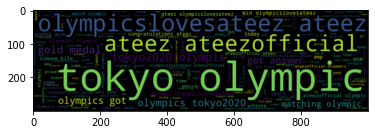

In [ ]:
allWords = ' '.join([twts for twts in dataset['tweets']])
WordCloud = WordCloud(width=1000, height=300, random_state=20, max_font_size= 119).generate(allWords)

plt.imshow(WordCloud, interpolation='bilinear')

Dari visualisasi terlihat bahwa kata 'Tokyo' dan 'Olympic' adalah kata yang sering muncul

#### Persentase Positive tweets

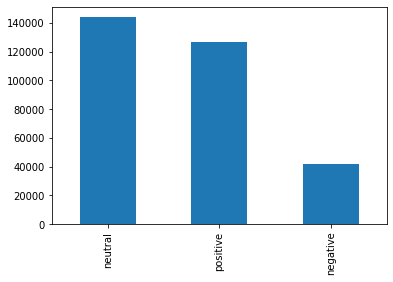

In [ ]:
dataset.Label.value_counts().plot(kind='bar');

In [ ]:
positive_tweet = dataset[dataset.Label == 'positive']['tweets']
neutral_tweet = dataset[dataset.Label == 'neutral']['tweets']
negative_tweet = dataset[dataset.Label == 'negative']['tweets']
print('Persentase Positive tweets = ',round((positive_tweet.shape[0] / dataset.shape[0])*100 ,2))
print('Persentase Neutral tweets = ',round((neutral_tweet.shape[0] / dataset.shape[0])*100 ,2))
print('Persentase Negative tweets = ',round((negative_tweet.shape[0] / dataset.shape[0])*100 ,2))

Persentase Positive tweets =  40.56
Persentase Neutral tweets =  46.04
Persentase Negative tweets =  13.4


#### Melihat Label tweets positive, neutral, dan negative

In [ ]:
random_index = random.randint(0, len(dataset)-5)

for row in dataset[["tweets", "Label"]][random_index:random_index+5].itertuples():
  _, text, target = row
  if target == "positive":
    print(f"Target: {target} (positive)")
  elif target == "neutral":
    print(f"Target: {target} (neutral)")
  else:
    print(f"Target: {target} (negative)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: neutral (neutral)
Text:
bbcnews brothera motorbike courier working london likes watch local london news 730am830…

---

Target: negative (negative)
Text:
well done teamgb diving sterling performance round sterling7 olympicgames olympics

---

Target: positive (positive)
Text:
britain bequeathed fair share olympic titans none plotted route greatness quite like p…

---

Target: neutral (neutral)
Text:
magicmonday trending twitter team gb take three golds tokyo 2020 🥇🥇🥇

---

Target: negative (negative)
Text:
manikabatra bows round 3 women’s tabletennis tenthseeded sofia polcanova aut final scor…

---



# Feature Engineering

#### Mengubah Categorical menjadi numerical pada features Label

In [ ]:
label_mapping = { k: i for i, k in enumerate(dataset['Label'].unique(), 0)}
label_mapping

{'negative': 1, 'neutral': 0, 'positive': 2}

In [ ]:
dataset['Label'] = dataset['Label'].map(label_mapping)

In [ ]:
dataset

,tweets,Subjectivity,Polarity,Label
0,rejected sports 2020 olympics include bowling ...,0.000000,0.000000,0
1,team usa men basketball team playing horrible ...,1.000000,-0.450000,1
2,myhiveaway im watching kayaking olympics broad...,0.575000,0.375000,2
3,girls age still trying figuring open account o...,0.350000,0.050000,2
4,omensfromeden patty mills olympics,0.000000,0.000000,0
...,...,...,...,...
312820,artistic swimming unreal olympics,1.000000,0.333333,2
312821,fzaq6zcw8avobp5 noormehrjavan olympics worldka...,0.000000,0.000000,0
312822,finally someone said ashutosh difference pseud...,0.533333,0.133333,2
312823,hnonoo75 olympics bahrainolympic congratulatio...,0.000000,0.000000,0


In [ ]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.10)

untuk menghindari adanya kemungkinan kebocoran data sehingga kita perlu membagi data terlebih dahulu dan kemudian menerapkan fitur engineering

In [ ]:
print(f"Total training samples: {len(train_dataset)}")
print(f"Total test samples: {len(test_dataset)}")
print(f"Total samples: {len(train_dataset) + len(test_dataset)}")

Total training samples: 281538
Total test samples: 31283
Total samples: 312821


In [ ]:
train_dataset

,tweets,Subjectivity,Polarity,Label
312696,bcci would get way india could compete gold cr...,0.000000,0.000000,0
95094,breaking world record lilly king reach semifin...,0.000000,0.000000,0
134233,watching olympics work vulnerable groups olymp...,0.400000,0.266667,2
227366,“black women apparently still expected sacrifi...,0.394444,-0.072222,1
288149,farhanisi talhatlb aray bhai ye olympics 2020 ...,0.000000,0.000000,0
...,...,...,...,...
68421,parttime surf pro knocks australia’s seventime...,0.000000,0.000000,0
69672,watch tokyo olympics clips day 2,0.000000,0.000000,0
183066,best video olympics far alwayssupportyourteamm...,0.650000,0.550000,2
146007,osakathiem everyday olympics week,0.600000,-0.200000,1


In [ ]:
test_dataset

,tweets,Subjectivity,Polarity,Label
133750,qianjinghua maxwalden cannot believe casually ...,0.883333,0.050000,2
260513,sournelaa enhypen 2020 olympics enhypenontokyo...,0.000000,0.000000,0
306254,2020 tokyo olympics iran 3gold medals 2🥈silver...,0.000000,0.000000,0
101086,tokyo olympics live updates day 4 boxer lovlin...,0.500000,0.136364,2
185195,call sportsmanship 🤝 saudi arabian judoka taha...,0.000000,0.000000,0
...,...,...,...,...
213898,hope attorney keeps word gives trademark right...,0.650000,0.350000,2
74731,poland huge goose egg olympics…they dead last ...,0.455556,0.066667,2
290943,tag teammate riders grab hands slingshot fresh...,0.500000,0.300000,2
12295,wont see countrys flag podiums national colors...,0.000000,0.000000,0


### Data Preprocessing

#### Menyiapkan target

In [ ]:
X_train, y_train = train_dataset.tweets, train_dataset.Label
X_test, y_test = test_dataset.tweets, test_dataset.Label

In [ ]:
def prepare_targets(y_train, y_test):
    y_train_enc = to_categorical(y_train)
    y_test_enc = to_categorical(y_test)
    return y_train_enc, y_test_enc

y_train, y_test = prepare_targets(y_train, y_test)

In [ ]:
y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

#### Melakukan Split data

In [ ]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(X_train.to_numpy(),
                                                                            y_train,
                                                                            test_size=0.2,
                                                                            random_state=42)

#### Pipeline

#### Membangun Pipeline

In [ ]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "data"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    churn_dir = os.path.join("datasets", "tweets")
    os.makedirs(churn_dir, exist_ok=True)
    path_format = os.path.join(churn_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

In [ ]:
train_data = np.c_[train_sentences, train_labels]
valid_data = np.c_[val_sentences, val_labels]
header_cols = dataset.columns 
header = ",".join(header_cols)

In [ ]:
train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)

### Train dataset

In [ ]:
pd.read_csv(train_filepaths[0]).head()

,tweets,Subjectivity,Polarity,Label
0,'fun fact hosting 2028 summer olympics sofista...,0.0,0.0,1.0
1,'fantastic scenes family friends swimming coll...,0.0,0.0,1.0
2,'first olympic goal jamie neushul hits skipsho...,0.0,0.0,1.0
3,'djokovic denied olympic bronze throws racket',1.0,0.0,0.0
4,'gold medallist yang qian’s ‘lucky’ hair clip ...,0.0,0.0,1.0


In [ ]:
os.path.getsize(train_filepaths[0])

969261

In [ ]:
train_folder=('/').join(re.search('(.*)/(.*)/(.*)',train_filepaths[0], re.IGNORECASE).group(1,2))

In [ ]:
print(train_filepaths[0])
train_folder

datasets/tweets/my_train_00.csv


'datasets/tweets'

In [ ]:
full_csv = train_folder+'/full_train.csv'
with open(full_csv, "wt", encoding="utf-8") as f:
    if header is not None:
        f.write(header)
        f.write("\n")
    for row_idx in range(train_data.shape[0]):
        f.write(",".join([repr(col) for col in train_data[row_idx]]))
        f.write("\n")

In [ ]:
os.path.getsize(full_csv)

19392611

In [ ]:
pd.read_csv(full_csv).shape

(225230, 4)

In [ ]:
train_data = pd.read_csv(full_csv)

In [ ]:
train_data

,tweets,Subjectivity,Polarity,Label
0,'fun fact hosting 2028 summer olympics sofista...,0.0,0.0,1.0
1,'fantastic scenes family friends swimming coll...,0.0,0.0,1.0
2,'first olympic goal jamie neushul hits skipsho...,0.0,0.0,1.0
3,'djokovic denied olympic bronze throws racket',1.0,0.0,0.0
4,'gold medallist yang qian’s ‘lucky’ hair clip ...,0.0,0.0,1.0
...,...,...,...,...
225225,'lived us since one',1.0,0.0,0.0
225226,'tokyo olympics deeply hurt feelings chinese p...,1.0,0.0,0.0
225227,'ronda whyte got disqualified amp girl right s...,0.0,0.0,1.0
225228,'phew thought us it’s streaming olympics mess ...,0.0,1.0,0.0


### Valid dataset

In [ ]:
pd.read_csv(valid_filepaths[0]).head()

,tweets,Subjectivity,Polarity,Label
0,'one historical facts constantly think photo t...,1.0,0.0,0.0
1,'real tho would dcc even think coming back oly...,0.0,0.0,1.0
2,'jdestoop80 benjiman1983 sad part probably get...,0.0,1.0,0.0
3,'gong wins later would finished places 1 4 4 o...,0.0,0.0,1.0
4,'ind assured second medal tokyo2020 lovlina bo...,1.0,0.0,0.0


In [ ]:
os.path.getsize(valid_filepaths[0])

486168

In [ ]:
valid_folder=('/').join(re.search('(.*)/(.*)/(.*)',valid_filepaths[0], re.IGNORECASE).group(1,2))

In [ ]:
print(valid_filepaths[0])
valid_folder

datasets/tweets/my_valid_00.csv


'datasets/tweets'

In [ ]:
full_csv = valid_folder+'/full_train.csv'
with open(full_csv, "wt", encoding="utf-8") as f:
    if header is not None:
        f.write(header)
        f.write("\n")
    for row_idx in range(valid_data.shape[0]):
        f.write(",".join([repr(col) for col in valid_data[row_idx]]))
        f.write("\n")

In [ ]:
os.path.getsize(full_csv)

4847473

In [ ]:
pd.read_csv(full_csv).shape

(56308, 4)

In [ ]:
valid_data = pd.read_csv(full_csv)

In [ ]:
valid_data

,tweets,Subjectivity,Polarity,Label
0,'one historical facts constantly think photo t...,1.0,0.0,0.0
1,'real tho would dcc even think coming back oly...,0.0,0.0,1.0
2,'jdestoop80 benjiman1983 sad part probably get...,0.0,1.0,0.0
3,'gong wins later would finished places 1 4 4 o...,0.0,0.0,1.0
4,'ind assured second medal tokyo2020 lovlina bo...,1.0,0.0,0.0
...,...,...,...,...
56303,'nuriacruzcruz edinsu hey quick check olympics...,0.0,0.0,1.0
56304,'symtecboy piersmorgan ill take guy took fastb...,0.0,1.0,0.0
56305,'went looking opening ceremony came across cli...,1.0,0.0,0.0
56306,'elaine jogged 1076 claat know shackaberry hap...,0.0,0.0,1.0


#### Split train_sentences, val_sentences, train_labels,  val_labels 

In [ ]:
train_sentences,  train_labels = train_data.tweets, train_data.Label
val_sentences, val_labels  = valid_data.tweets, valid_data.Label

#### Menyiapkan Target

In [ ]:
X_train, y_train = train_dataset.tweets, train_dataset.Label
X_test, y_test = test_dataset.tweets, test_dataset.Label

In [ ]:
def prepare_targets(y_train, y_test):
    y_train_enc = to_categorical(y_train)
    y_test_enc = to_categorical(y_test)
    return y_train_enc, y_test_enc

y_train, y_test = prepare_targets(y_train, y_test)

#### Melakukan Split Data 

In [ ]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(X_train.to_numpy(),
                                                                            y_train,
                                                                            test_size=0.2,
                                                                            random_state=42)

In [ ]:
def counter_word(text):
  count = Counter()
  for i in text.values:
      for word in i.split():
          count[word] += 1
  return count

In [ ]:
text = dataset['tweets']
counter = counter_word(text)

In [ ]:
max_vocab_length = len(counter)
max_vocab_length

185954

#### Menghitung

In [ ]:
# max number of words in a squance
max_length = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))
max_length

10

## Tokenizer

#### Setup text vectorization 

In [ ]:
text_vectorizer = TextVectorization(max_tokens=max_vocab_length, 
                                    split="whitespace", 
                                    output_sequence_length=max_length)

In [ ]:
text_vectorizer.adapt(train_sentences)

#### Buat contoh Tweets untuk membuktikan tokenizer bekerja

In [ ]:
sample_sentence = "Why is the Team USA men basketball team"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 10), dtype=int64, numpy=array([[  1,   1,   1,  12,  32, 217,  70,  12,   0,   0]])>

In [ ]:
random_sentence = random.choice(train_sentences)
print(f"Teks Asli:\n{random_sentence}\
      \n\nVersi Vektorisasi:")
text_vectorizer([random_sentence])

Teks Asli:
nbc failing olympics badly putting winner medal broadcasts usually…      

Versi Vektorisasi:


<tf.Tensor: shape=(1, 10), dtype=int64, numpy=
array([[  185,  1764,     2,  3253,  1125,   571,     8,  7534, 25201,
            0]])>

In [ ]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # token terbanyak
bottom_5_words = words_in_vocab[-5:] # token tersedikit
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 151288
Top 5 most common words: ['', '[UNK]', 'olympics', 'tokyo', 'ateezofficial']
Bottom 5 least common words: ['0005seconds…', '000101jd', '0000m', '0000000000', '000000']


#### Load GloVe Model

In [ ]:
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(dataset['tweets'])

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

unique tokens -  185954
vocab size - 185955


In [ ]:
embeddings_index = {}
embedding_dim = 100
GLOVE_DIR = "/content/drive/MyDrive/final_project/glove.twitter.27B.100d.txt"
f = open(os.path.join(GLOVE_DIR, '/content/drive/MyDrive/final_project/glove.twitter.27B.100d.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


## membuat embedding layers

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)

50399


In [ ]:
embedding_glove = layers.Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [ ]:
embedding_glove

In [ ]:
random_sentence = random.choice(train_sentences)

In [ ]:
random_sentence

'yas summer olympics 2021 helwelsmith center pools'

In [ ]:
sample_embed = embedding_glove(text_vectorizer([random_sentence]))
print(f"Teks Asli:\n{random_sentence}\
      \n\nVersi Embedded:", sample_embed)

Teks Asli:
yas summer olympics 2021 helwelsmith center pools      

Versi Embedded: tf.Tensor(
[[[ 0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         

# Pendefinisian dan Pelatihan Model

#### Permodelan LSTM dengan GloVe weight initialization

In [ ]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding_glove(x)
print(x.shape)
x = layers.LSTM(64, dropout=0.5)(x) 
print(x.shape)
outputs = layers.Dense(3, activation="softmax")(x)
model_LSTM_GloVe = tf.keras.Model(inputs, outputs, name="model_LSTM_GloVe")

(None, 10, 100)
(None, 64)


menggunakan activation softmax karena output berupa 3 kategori

In [ ]:
model_LSTM_GloVe.summary()

Model: "model_LSTM_GloVe"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 10)                0         
_________________________________________________________________
embedding (Embedding)        (None, 10, 100)           18595500  
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 18,637,935
Trainable params: 42,435
Non-trainable params: 18,595,500
_________________________________________________________________


## Fit Model

#### Compile model LSTM with Glove

In [ ]:
model_LSTM_GloVe.compile(loss="categorical_crossentropy",
                         optimizer=tf.keras.optimizers.Adam(),
                         metrics=["accuracy"])

#### Training model LSTM with Glove

In [ ]:
model_LSTM_GloVe_history = model_LSTM_GloVe.fit(train_sentences,
                                                train_labels,
                                                batch_size=32, 
                                                epochs=75,
                                                validation_data=(val_sentences, val_labels),
                                                verbose=2)

Epoch 1/75
7039/7039 - 58s - loss: 0.8155 - accuracy: 0.6293 - val_loss: 0.6667 - val_accuracy: 0.7260
Epoch 2/75
7039/7039 - 55s - loss: 0.7165 - accuracy: 0.6935 - val_loss: 0.6161 - val_accuracy: 0.7578
Epoch 3/75
7039/7039 - 55s - loss: 0.6765 - accuracy: 0.7205 - val_loss: 0.5801 - val_accuracy: 0.7846
Epoch 4/75
7039/7039 - 56s - loss: 0.6501 - accuracy: 0.7369 - val_loss: 0.5498 - val_accuracy: 0.8004
Epoch 5/75
7039/7039 - 56s - loss: 0.6310 - accuracy: 0.7500 - val_loss: 0.5376 - val_accuracy: 0.8047
Epoch 6/75
7039/7039 - 55s - loss: 0.6170 - accuracy: 0.7576 - val_loss: 0.5288 - val_accuracy: 0.8089
Epoch 7/75
7039/7039 - 56s - loss: 0.6064 - accuracy: 0.7644 - val_loss: 0.5228 - val_accuracy: 0.8110
Epoch 8/75
7039/7039 - 55s - loss: 0.5975 - accuracy: 0.7684 - val_loss: 0.5103 - val_accuracy: 0.8175
Epoch 9/75
7039/7039 - 56s - loss: 0.5905 - accuracy: 0.7725 - val_loss: 0.5045 - val_accuracy: 0.8207
Epoch 10/75
7039/7039 - 56s - loss: 0.5858 - accuracy: 0.7751 - val_loss:

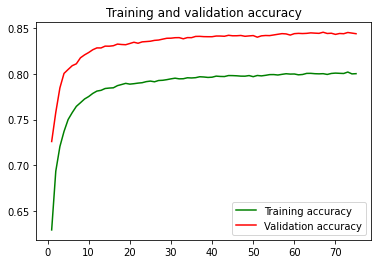

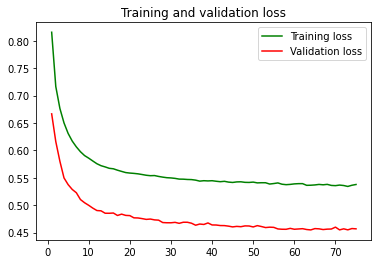

In [91]:
# Plot results
acc = model_LSTM_GloVe_history.history["accuracy"]
val_acc = model_LSTM_GloVe_history.history['val_accuracy']
loss = model_LSTM_GloVe_history.history['loss']
val_loss = model_LSTM_GloVe_history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Model LSTM with word2vec Evaluation

In [ ]:
y_pred = model_LSTM_GloVe.predict(val_sentences)

In [92]:
def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [93]:
model_LSTM_GloVe_results = calculate_results(y_true= val_labels.argmax(axis=1), 
                                    y_pred= y_pred.argmax(axis=1))
model_LSTM_GloVe_results

{'accuracy': 84.38587767279961,
 'f1': 0.8376270659595391,
 'precision': 0.8574184866823014,
 'recall': 0.843858776727996}

# Model Evaluation

In [94]:
print('Hasil Performa dengan Layers Embedding :')
print('\n',model_LSTM_GloVe_results)

Hasil Performa dengan Layers Embedding :

 {'accuracy': 84.38587767279961, 'precision': 0.8574184866823014, 'recall': 0.843858776727996, 'f1': 0.8376270659595391}


# Data Inference

#### membuat data baru

In [95]:
new_tweets = [
            "Japanese nationalists are targeting their own medals",
            "The Indian mens hockey team beat current Olympycs",
            "Wales wins its firstever Olympic gold after 20 years"
]

#### melakukan prediksi terhadap data baru

In [96]:
predict = model_LSTM_GloVe.predict(new_tweets)
predict.argmax(axis=1)

array([0, 0, 2])

dari hasil prediksi dengan menggunakan data baru didapatkan hasil sebagai berikut:
* tweet pertama termasuk kedalam label tweet Netral
* tweet kedua termasuk kedalam label tweet Netral
* tweet ketiga termasuk kedalam label tweet Positive